In [1]:
!python -V
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import gpytorch as gp


rng = np.random.default_rng(1234)

Python 3.13.3


# Question 1

# Question 2

## (a)

Set $\sigma(R_1, R_2) = \beta_0 + \beta_1 R_1 + \beta_2 \sqrt{R_2}$. Then for the model

$$
\begin{align*}
    dS_t &= S_t \sigma(R_{1, t}, R_{2, t}) dW_t \\
    dR_{1, t} &= \lambda_1 \sigma(R_{1, t}, R_{2, t}) dW_t - \lambda_1 R_{1, t} dt \\
    dR_{2, t} &= \lambda_2 \left( \sigma(R_{1, t}, R_{2, t})^2 - R_{2, t} \right) dt
\end{align*}
$$

We will use the Euler-Maruyama discretization

$$
\begin{align*}
    \hat{S}_{n+1} &= \hat{S}_{n} + \hat{S}_{n} \sigma(\hat{R}_{1, n}, \hat{R}_{2, n}) \Delta W_n \\
    \hat{R}_{1, n+1} &= \hat{R}_{1, n} + \lambda_1 \sigma(\hat{R}_{1, n}, \hat{R}_{2, n}) \Delta W_n - \lambda_1 \hat{R}_{1, n} \Delta t \\
    \hat{R}_{2, n+1} &= \hat{R}_{2, n} + \lambda_2 \left( \sigma(\hat{R}_{1, n}, \hat{R}_{2, n})^2 - \hat{R}_{2, n} \right) \Delta t
\end{align*}
$$

In [2]:
def sigma(r1, r2, *, b0=0.08, b1=-0.08, b2=0.5):
    return b0 + b1 * r1 + b2 * np.sqrt(r2)

def generate_mc_samples(
    *,
    S0: float = 8.0,
    R10: float = -0.044,
    R20: float = 0.007,
    lambda1: float = 62,
    lambda2: float = 40,
    dt: float = 0.001,
    T: float = 0.33,
    M: int = 1000,
    dW: np.ndarray | None = None
) -> np.ndarray:
    path_length = int(T / dt) + 1 # 0, dt, ..., T

    S = np.empty((M, path_length))
    R1 = np.empty((M, path_length))
    R2 = np.empty((M, path_length))

    S[:, 0], R1[:, 0], R2[:, 0] = S0, R10, R20

    dW = dW if dW is not None else rng.normal(scale=np.sqrt(dt), size=(M, path_length-1))

    for i in range(path_length-1):
        Sn, R1n, R2n, dWn = S[:, i], R1[:, i], R2[:, i], dW[:, i]
        
        S[:, i+1] = Sn + Sn * sigma(R1n, R2n) * dWn
        R1[:, i+1] = R1n + lambda1 * sigma(R1n, R2n) * dWn - lambda1 * R1n * dt
        R2[:, i+1] = R2n + lambda2 * (sigma(R1n, R2n)**2 - R2n) * dt

    return S

In [3]:
def get_payoff(S0: float, *, M: int = 1000, dW: np.ndarray | None = None):
    simulation = generate_mc_samples(S0=S0, M=M, dW=dW)
    return np.average(np.maximum(simulation[:, -1] - 10, 0))

def get_delta(S0: float, *, eps: float = 5e-3, M: int = 1000) -> float:
    dW = rng.normal(scale=np.sqrt(0.001), size=(M, 330))

    top_payoff = get_payoff(S0 + eps, M=M, dW=dW)
    bottom_payoff = get_payoff(S0 - eps, M=M, dW=dW)

    return (top_payoff - bottom_payoff) / (2 * eps)

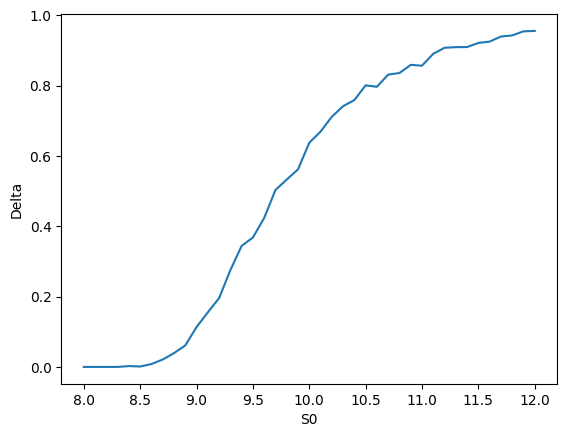

In [4]:
s_range = np.linspace(8, 12, int(4 / 0.1) + 1)

delta_mc = np.array([get_delta(s) for s in s_range])

ax = sns.lineplot(x=s_range, y=delta_mc)
ax.set_xlabel('S0')
ax.set_ylabel('Delta')

plt.show()

## (b)

In [5]:
data = torch.tensor(s_range, requires_grad=True)
target = torch.tensor([get_payoff(s) for s in s_range])

class GP(gp.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=2.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        cov_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, cov_x)

likelihood=gp.likelihoods.GaussianLikelihood()
gp_surrogate = GP(data, target, likelihood=likelihood)

def train_gp(model: GP, lik: gp.likelihoods.Likelihood, inp: torch.Tensor, targ: torch.Tensor, epochs: int):
    # code adapted from: https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html
    model.train()
    lik.train()

    optimizer = optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    mll = gp.mlls.ExactMarginalLogLikelihood(lik, model)

    for epoch in range(epochs):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = gp_surrogate(inp)
        # Calc loss and backprop gradients
        loss = -mll(output, targ)
        loss.backward()
        if epoch % 100 == 0:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                epoch + 1, epochs, loss.item(),
                gp_surrogate.covar_module.base_kernel.lengthscale.item(),
                gp_surrogate.likelihood.noise.item()
            ))
        optimizer.step()

    model.eval()
    lik.eval()

In [6]:
train_gp(gp_surrogate, likelihood, data, target, 1000)

Iter 1/1000 - Loss: 0.945   lengthscale: 0.693   noise: 0.693
Iter 101/1000 - Loss: -2.179   lengthscale: 4.728   noise: 0.000
Iter 201/1000 - Loss: -2.185   lengthscale: 3.683   noise: 0.000
Iter 301/1000 - Loss: -2.185   lengthscale: 3.653   noise: 0.000
Iter 401/1000 - Loss: -2.185   lengthscale: 3.653   noise: 0.000
Iter 501/1000 - Loss: -2.185   lengthscale: 3.653   noise: 0.000
Iter 601/1000 - Loss: -2.185   lengthscale: 3.653   noise: 0.000
Iter 701/1000 - Loss: -2.185   lengthscale: 3.653   noise: 0.000
Iter 801/1000 - Loss: -2.185   lengthscale: 3.653   noise: 0.000
Iter 901/1000 - Loss: -2.185   lengthscale: 3.653   noise: 0.000


c:\Users\holyd_lrfudwy\AppData\Local\Programs\Python\Python313\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


<Axes: >

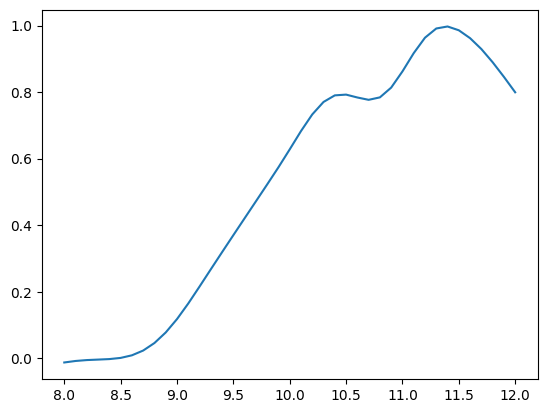

In [7]:
# evaluate gradient of model w.r.t input
out = likelihood(gp_surrogate(data)).mean

# could not figure out how to get the derivatives directly,
# so instead compute jacobian and take diagonal
jac = torch.autograd.functional.jacobian(lambda x: likelihood(gp_surrogate(x)).mean, data)

delta_gp = torch.diagonal(jac)

sns.lineplot(x=data.detach().numpy(), y=delta_gp.detach().numpy())

To compare the answers from (a), (b)

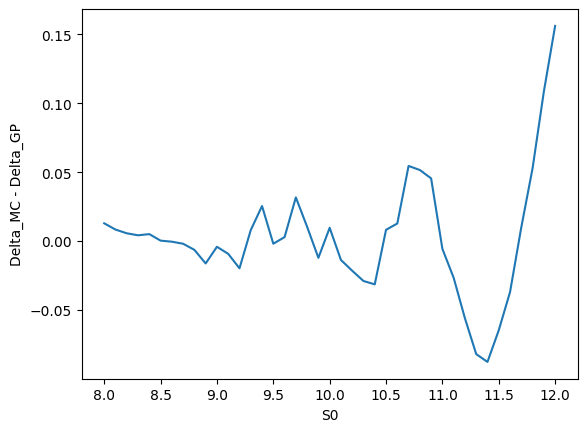

In [8]:
diff_ax = sns.lineplot(x=s_range, y=delta_mc - delta_gp.detach().numpy())
diff_ax.set_xlabel('S0')
diff_ax.set_ylabel('Delta_MC - Delta_GP')

plt.show()

Both methods are performing very similarly at the left endpoint and for most of the middle region, staying within 5 cents of each other. However, towards the right endpoint, they diverge and perform differently.

# Question 3

In [9]:
class NN(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.layer1 = nn.Linear(1, 30, dtype=torch.float64)
        self.layer2 = nn.Linear(30, 30, dtype=torch.float64)
        self.layer3 = nn.Linear(30, 1, dtype=torch.float64)
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x

def train_nn(model: NN, inp: torch.Tensor, out: torch.Tensor, epochs: int):
    model.train()
    mse = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        optimizer.zero_grad()
        pred = model(inp)
        loss = mse(pred, out)

        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f'{model.activation} Epoch {epoch}/{epochs}: Loss = {loss.item()}')

    model.eval()

In [10]:
data.grad = None

model_relu  = NN(nn.ReLU())
model_tanh  = NN(nn.Tanh())
model_elu   = NN(nn.ELU())

train_nn(model_relu, data.unsqueeze(1), target.unsqueeze(1), 1000)
print()
train_nn(model_tanh, data.unsqueeze(1), target.unsqueeze(1), 1000)
print()
train_nn(model_elu, data.unsqueeze(1), target.unsqueeze(1), 1000)

ReLU() Epoch 0/1000: Loss = 0.40789507307576306
ReLU() Epoch 100/1000: Loss = 0.26809599101091697
ReLU() Epoch 200/1000: Loss = 0.11717024178399303
ReLU() Epoch 300/1000: Loss = 0.042202726487675965
ReLU() Epoch 400/1000: Loss = 0.0317757529224581
ReLU() Epoch 500/1000: Loss = 0.028889524251469213
ReLU() Epoch 600/1000: Loss = 0.0255094157843812
ReLU() Epoch 700/1000: Loss = 0.022019118409312137
ReLU() Epoch 800/1000: Loss = 0.018225259519295663
ReLU() Epoch 900/1000: Loss = 0.014609468940392424

Tanh() Epoch 0/1000: Loss = 0.6740748159031904
Tanh() Epoch 100/1000: Loss = 0.4053882535175552
Tanh() Epoch 200/1000: Loss = 0.07796672840763372
Tanh() Epoch 300/1000: Loss = 0.04545277545380268
Tanh() Epoch 400/1000: Loss = 0.03818026519647599
Tanh() Epoch 500/1000: Loss = 0.030846241576284454
Tanh() Epoch 600/1000: Loss = 0.021379497133304826
Tanh() Epoch 700/1000: Loss = 0.011839650969219045
Tanh() Epoch 800/1000: Loss = 0.005122742954581925
Tanh() Epoch 900/1000: Loss = 0.0022168072466363

In [11]:
def compute_delta(model: NN, inp: torch.Tensor = data) -> torch.Tensor:
    jac = torch.autograd.functional.jacobian(model, inp.unsqueeze(1)).squeeze()

    return torch.diagonal(jac)

relu_delta = compute_delta(model_relu)
tanh_delta = compute_delta(model_tanh)
elu_delta = compute_delta(model_elu)

display(tanh_delta)

tensor([0.0696, 0.0777, 0.0869, 0.0971, 0.1085, 0.1212, 0.1352, 0.1509, 0.1681,
        0.1872, 0.2081, 0.2311, 0.2563, 0.2837, 0.3134, 0.3454, 0.3798, 0.4165,
        0.4553, 0.4961, 0.5385, 0.5822, 0.6266, 0.6711, 0.7151, 0.7578, 0.7983,
        0.8359, 0.8697, 0.8990, 0.9231, 0.9416, 0.9540, 0.9603, 0.9605, 0.9547,
        0.9434, 0.9271, 0.9065, 0.8822, 0.8549], dtype=torch.float64)

C:\Users\holyd_lrfudwy\AppData\Local\Temp\ipykernel_39396\4215766548.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


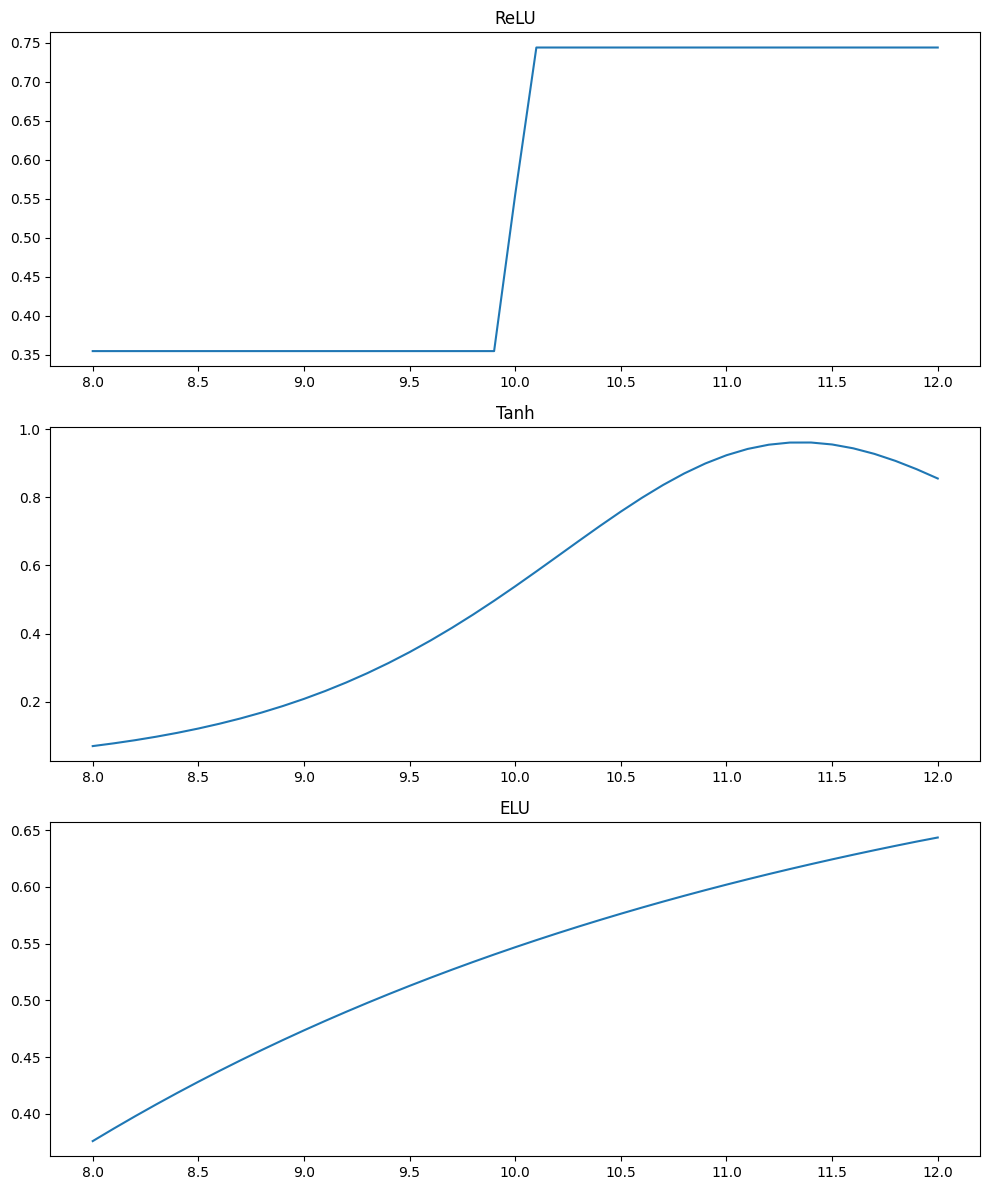

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))


d = data.detach().numpy()
relu_graph  = sns.lineplot(x=d, y=relu_delta.numpy(), ax=axes[0])
tanh_graph  = sns.lineplot(x=d, y=tanh_delta.numpy(), ax=axes[1])
elu_graph   = sns.lineplot(x=d, y=elu_delta.numpy(), ax=axes[2])

relu_graph.set_title('ReLU')
tanh_graph.set_title('Tanh')
elu_graph.set_title('ELU')

fig.tight_layout()
fig.show()

The ReLU model is performing very poorly, as it is piecewise constant with one jump. Empirically, the Tanh model has a greater range than the ELU model, and this range is consistent with the results from Question 2, so I believe Tanh is performing the best.

C:\Users\holyd_lrfudwy\AppData\Local\Temp\ipykernel_39396\1615937078.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


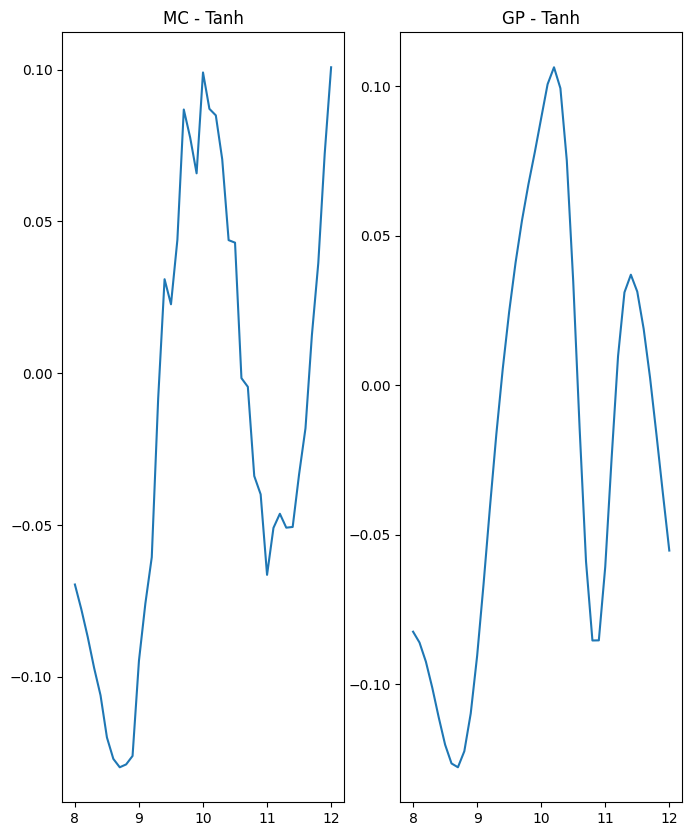

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 10))

tanh_vs_mc = sns.lineplot(x=d, y=delta_mc - tanh_delta.numpy(), ax=axes[0])
tanh_vs_gp = sns.lineplot(x=d, y=delta_gp.numpy() - tanh_delta.numpy(), ax=axes[1])

tanh_vs_mc.set_title('MC - Tanh')
tanh_vs_gp.set_title('GP - Tanh')

fig.show()

Compared to Question 2, the errors are large. The Tanh-NN overshoots and undershoots both prices by 10 cents. Considering that both MC and GP Deltas were fairly close to each other, I believe it's safe to conclude that the Tanh NN is not performing as well and requires more layers.